In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [50]:
@dataclass
class GANConfig:
    name: str = "Baseline"
    batch_size: int = 32
    z_dim: int = 100
    lob_dim: int = 40
    epochs: int = 10
    learning_rate_d: float = 0.0002
    learning_rate_g: float = 0.0002
    beta1: float = 0.5
    beta2: float = 0.999
    label_smoothing: float = 0.0
    use_feature_matching: bool = False
    feature_matching_weight: float = 1.0
    # use_vbn: bool = False
    use_historical_avg: bool = False
    historical_averaging_weight: float = 0.0001
    generator_target_prob: float = 1.0
    use_minibatch_discrimination: bool = False

config = GANConfig()

Load LOB data

In [46]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")

# Load and preprocess LOB data
file_path = "/content/drive/MyDrive/BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

df = df.dropna(subset=lob_features).sample(n=5000)
scaler = MinMaxScaler()
lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32)

bid_p = lob_data[:, :10]
bid_v = lob_data[:, 10:20]
ask_p = lob_data[:, 20:30]
ask_v = lob_data[:, 30:40]

lob_dataset = tf.data.Dataset.from_tensor_slices((bid_p, bid_v, ask_p, ask_v)).batch(config.batch_size)
# lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Generator and Discriminator Network

In [ ]:
class Generator(models.Model):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim

        # self.create_feature = tf.keras.Sequential([
        #     tf.keras.layers.Dense(64, activation="relu"),
        #     tf.keras.layers.Dense(32, activation="relu"),
        #     tf.keras.layers.Dense(20, activation=None)  # output bid_v + ask_v/bid_v + ask_v
        # ])

        self.price_output = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="leaky_relu"),
            tf.keras.layers.Dense(64, activation="leaky_relu"),
            tf.keras.layers.Dense(20, activation=None)  # bid_p + ask_p
        ])

        self.volume_output = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(20, activation=None)  # bid_v + ask_v
        ])

    def call(self, inputs):
        diffs = self.price_output(inputs)
        bid_diffs = diffs[:, :10]
        ask_diffs = diffs[:, 10:]

        # Strictly decreasing by inverting + accumulating + inverting again
        reversed_bid_diffs = tf.reverse(bid_diffs, axis=[1])
        reversed_bid_p = tf.cumsum(reversed_bid_diffs, axis=1)
        bid_p = tf.reverse(reversed_bid_p, axis=[1])

        base_ask = bid_p[:, :1] + 1e-5  # ensure min(bid_price)>max(ask_price)
        ask_p = tf.cumsum(ask_diffs, axis=1)

        volumes = self.volume_output(inputs)
        bid_v = volumes[:, :10]
        ask_v = volumes[:, 10:]

        return bid_p, bid_v, ask_p, ask_v

class Discriminator(models.Model):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config
        self.use_minibatch = config.use_minibatch_discrimination

        self.price_block = tf.keras.Sequential([
            layers.Dense(128, activation=None),
            layers.LeakyReLU(0.2),
            layers.Dense(64),
            layers.Dropout(0.3)
        ])

        self.volume_block = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu')
        ])

        self.fusion = tf.keras.layers.Dense(1, activation=None)

    def call(self, bid_p, bid_v, ask_p, ask_v):
        price_input = tf.concat([bid_p, ask_p], axis=1)
        price_out = self.price_block(price_input)

        volume_input = tf.concat([bid_v, ask_v], axis=1)
        volume_out = self.volume_block(volume_input)

        combined = tf.concat([price_out, volume_out], axis=1)
        output = self.fusion(combined)
        return output

Improvement Methods

In [6]:
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        self.input_dim = input_shape[1]
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel)
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])

        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        diff = expanded_act - transposed_act
        abs_diff = tf.reduce_sum(tf.abs(diff), 2)

        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size)
        mask = tf.expand_dims(mask, 1)

        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        exp = tf.exp(-abs_diff) * mask
        minibatch_features = tf.reduce_sum(exp, 2)

        return tf.concat([inputs, minibatch_features], axis=1)

class VirtualBatchNormalization(layers.Layer):
    """Virtual Batch Normalization Layer"""

    def __init__(self, epsilon=1e-5, **kwargs):
        super(VirtualBatchNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.reference_batch_set = False

    def build(self, input_shape):
        self.ndim = len(input_shape)
        shape = [1] * self.ndim
        shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(1.0, 0.02),
            name='gamma',
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.zeros_initializer(),
            name='beta',
            trainable=True
        )

        self.ref_mean = self.add_weight(
            shape=shape,
            initializer=tf.zeros_initializer(),
            name='ref_mean',
            trainable=False
        )
        self.ref_var = self.add_weight(
            shape=shape,
            initializer=tf.ones_initializer(),
            name='ref_var',
            trainable=False
        )

        super(VirtualBatchNormalization, self).build(input_shape)

    def _get_axis(self):
        return list(range(self.ndim - 1))

    def set_reference_batch(self, x):
        axes = self._get_axis()
        mean = tf.reduce_mean(x, axis=axes, keepdims=True)
        var = tf.reduce_mean(tf.square(x - mean), axis=axes, keepdims=True)

        self.ref_mean.assign(mean)
        self.ref_var.assign(var)
        self.reference_batch_set = True

    def call(self, inputs, set_reference=False, **kwargs):
        if set_reference or not self.reference_batch_set:
            axes = self._get_axis()
            ref_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            ref_var = tf.reduce_mean(tf.square(inputs - ref_mean), axis=axes, keepdims=True)

            self.ref_mean.assign(ref_mean)
            self.ref_var.assign(ref_var)
            self.reference_batch_set = True

            batch_mean = ref_mean
            batch_var = ref_var
        else:
            axes = self._get_axis()
            batch_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            batch_var = tf.reduce_mean(tf.square(inputs - batch_mean), axis=axes, keepdims=True)

            batch_mean = 0.5 * (batch_mean + self.ref_mean)
            batch_var = 0.5 * (batch_var + self.ref_var)

        batch_var = tf.maximum(batch_var, self.epsilon)

        x_norm = (inputs - batch_mean) / tf.sqrt(batch_var)

        gamma_reshaped = self.gamma
        beta_reshaped = self.beta

        if self.ndim > 2:
            gamma_reshaped = tf.reshape(self.gamma, [1] * (self.ndim - 1) + [self.gamma.shape[0]])
            beta_reshaped = tf.reshape(self.beta, [1] * (self.ndim - 1) + [self.beta.shape[0]])

        return x_norm * gamma_reshaped + beta_reshaped

class FeatureMatching:
    """Feature matching loss"""

    def __call__(self, real_features, fake_features):
        real_mean = tf.reduce_mean(real_features, axis=0)
        fake_mean = tf.reduce_mean(fake_features, axis=0)
        return tf.reduce_mean(tf.square(real_mean - fake_mean))

class HistoricalAveraging:
    """
    Historical averaging to prevent oscillation in GAN training.
    This version avoids creating Variables inside tf.function.
    """

    def __init__(self, beta=0.99):
        self.beta = beta
        self.parameter_history = {}

    def initialize_if_needed(self, model):
        """Initialize parameter history outside of tf.function"""
        model_keys = [weight.name for weight in model.trainable_weights]

        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        if not self.parameter_history:
            return tf.constant(0.0)

        total_loss = 0.0

        for curr_weight in model.trainable_weights:
            name = curr_weight.name

            if name not in self.parameter_history:
                continue

            curr_value = curr_weight
            hist_value = self.parameter_history[name]

            if curr_value.shape == hist_value.shape:
                hist_tensor = tf.convert_to_tensor(hist_value, dtype=curr_value.dtype)
                diff = curr_value - hist_tensor
                loss = tf.reduce_sum(tf.square(diff))
                total_loss += loss

        return weight * total_loss

    def update_history(self, model):
        """Update parameter history - call this AFTER each training step"""
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                curr_value = weight.numpy()
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * curr_value

Distribution and KL divergence

In [7]:
def compare_distributions(real_df, syn_df, bins=50, epsilon=1e-10):

    plot_features = ['b0p', 'b9p', 'b0q', 'b9q', 'a0p', 'a9p', 'a0q', 'a9q']

    kl_results = {}
    all_features = real_df.columns

    for feature in all_features:
        real_vals = real_df[feature].dropna().values
        syn_vals = syn_df[feature].dropna().values

        min_val = min(np.min(real_vals), np.min(syn_vals))
        max_val = max(np.max(real_vals), np.max(syn_vals))
        bin_edges = np.linspace(min_val, max_val, bins + 1)

        p, _ = np.histogram(real_vals, bins=bin_edges, density=True)
        q, _ = np.histogram(syn_vals, bins=bin_edges, density=True)

        p = np.where(p == 0, epsilon, p)
        q = np.where(q == 0, epsilon, q)

        p = p / p.sum()
        q = q / q.sum()

        kl_divergence = entropy(p, q)
        kl_results[feature] = kl_divergence

    plt.figure(figsize=(8, 16))
    for i, feature in enumerate(plot_features, 1):
        plt.subplot(4, 2, i)

        sns.kdeplot(real_df[feature], label='Real Data', fill=True, alpha=0.5)
        sns.kdeplot(syn_df[feature], label='Synthetic Data', fill=True, alpha=0.5)

        plt.title(f'{feature} Distribution', fontsize=10)
        plt.xlabel('')
        plt.ylabel('Density', fontsize=8)
        plt.legend(fontsize=8)

        plt.text(0.7, 0.85, f'KL: {kl_results[feature]:.4f}',
                transform=plt.gca().transAxes,
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    kl_values = list(kl_results.values())
    stats = {
        'max_kl': np.max(kl_values),
        'min_kl': np.min(kl_values),
        'mean_kl': np.mean(kl_values),
        'kl_divergences': kl_results
    }

    return stats

Training

In [51]:
class GANTrainer:
    def __init__(self, config: GANConfig, scaler, data_dim=40):
        self.config = config
        self.scaler = scaler

        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_g,
            beta_1=config.beta1,
            beta_2=config.beta2
        )
        self.disc_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_d,
            beta_1=config.beta1,
            beta_2=config.beta2
        )

        if config.use_feature_matching:
            self.feature_matching = FeatureMatching()

        if config.use_historical_avg:
            self.historical_averaging = HistoricalAveraging(beta=0.99)

    def disc_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output) * (1.0 - self.config.label_smoothing)
        fake_labels = tf.zeros_like(fake_output)

        real_loss = self.loss_fn(real_labels, real_output)
        fake_loss = self.loss_fn(fake_labels, fake_output)

        total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)

        if self.config.use_historical_avg:
            ha_loss = self.historical_averaging(
                self.discriminator,
                self.config.historical_averaging_weight
            )
            total_loss += ha_loss

        return total_loss

    def gen_loss(self, fake_output):
        target_labels = tf.ones_like(fake_output) * self.config.generator_target_prob

        total_loss = tf.reduce_mean(self.loss_fn(target_labels, fake_output))

        if self.config.use_historical_avg:
            ha_loss = self.historical_averaging(
                self.generator,
                self.config.historical_averaging_weight
            )
            total_loss += ha_loss

        return total_loss

    def lob_metrics(self, fake_data):
        lob_np = self.scaler.inverse_transform(fake_data.numpy())

        bid_p = lob_np[:, :10]
        ask_p = lob_np[:, 20:30]
        bid_q = lob_np[:, 10:20]
        ask_q = lob_np[:, 30:40]

        metrics = {}

        metrics['neg_count'] = np.sum(bid_q < 0) + np.sum(ask_q < 0)
        metrics['neg_sum'] = np.sum(bid_q[bid_q < 0]) + np.sum(ask_q[ask_q < 0])

        def level_diff_stats(prices, is_bid):
            if is_bid:
                diffs = prices[:, :-1] - prices[:, 1:]  # price[i] - price[i+1]
            else:
                diffs = prices[:, 1:] - prices[:, :-1]  # price[i+1] - price[i]

            violations = np.sum(diffs < 0)
            sum_positive = np.sum(np.maximum(0, diffs))

            return violations, sum_positive

        metrics['bid_higher'], metrics['sum_bid_prev'] = level_diff_stats(bid_p, is_bid=True)
        metrics['ask_lower'], metrics['sum_ask_next'] = level_diff_stats(ask_p, is_bid=False)

        return metrics


    def _train_step(self, real_data: tf.Tensor) -> Tuple[float, float, float, float]:
        bid_p_real, bid_v_real, ask_p_real, ask_v_real = real_data

        batch_size = tf.shape(real_data)[0]
        z = tf.random.normal((batch_size, self.config.z_dim))

        with tf.GradientTape() as tape_d:
            bid_p_fake, bid_v_fake, ask_p_fake, ask_v_fake = self.generator(z)

            real_output = self.discriminator(bid_p_real, bid_v_real, ask_p_real, ask_v_real)
            fake_output = self.discriminator(bid_p_fake, bid_v_fake, ask_p_fake, ask_v_fake)

            loss_d = self.disc_loss(real_output, fake_output)

        grads_d = tape_d.gradient(loss_d, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))


        with tf.GradientTape() as tape_g:
            bid_p_fake, bid_v_fake, ask_p_fake, ask_v_fake = self.generator(z)
            fake_output = self.discriminator(bid_p_fake, bid_v_fake, ask_p_fake, ask_v_fake)

            loss_g = self.gen_loss(fake_output)
        grads_g = tape_g.gradient(loss_g, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables))

        fake_data = tf.concat([bid_p_fake, bid_v_fake, ask_p_fake, ask_v_fake], axis=1)
        metrics = self.lob_metrics(fake_data)

        return (
            loss_d.numpy().mean(),
            loss_g.numpy().mean(),
            metrics['neg_count'],
            metrics['neg_sum'],
            metrics['bid_higher'],
            metrics['ask_lower'],
            metrics['sum_bid_prev'],
            metrics['sum_ask_next']
        )

    def train(self, dataset: tf.data.Dataset) -> Dict:
        history = {
            'd_loss': [], 'g_loss': [],
            'neg_count': [], 'neg_sum': [],
            'bid_higher': [], 'ask_lower': [],
            'sum_bid_prev': [], 'sum_ask_next': []
        }

        if self.config.use_historical_avg:
            self.historical_averaging.initialize_if_needed(self.generator)
            self.historical_averaging.initialize_if_needed(self.discriminator)

        start_time = time.time()

        with tqdm(total=self.config.epochs,
                desc=f"Training {self.config.name}",
                bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:

            for epoch in range(self.config.epochs):
                epoch_metrics = {
                'd_loss': [], 'g_loss': [],
                'neg_count': [], 'neg_sum': [],
                'bid_higher': [], 'ask_lower': [],
                'sum_bid_prev': [], 'sum_ask_next': []
            }

                for real_batch in dataset:
                    results = self._train_step(real_batch)

                    if self.config.use_historical_avg:
                      self.historical_averaging.update_history(self.generator)
                      self.historical_averaging.update_history(self.discriminator)

                    epoch_metrics['d_loss'].append(results[0])
                    epoch_metrics['g_loss'].append(results[1])
                    epoch_metrics['neg_count'].append(results[2])
                    epoch_metrics['neg_sum'].append(results[3])
                    epoch_metrics['bid_higher'].append(results[4])
                    epoch_metrics['ask_lower'].append(results[5])
                    epoch_metrics['sum_bid_prev'].append(results[6])
                    epoch_metrics['sum_ask_next'].append(results[7])

                for key in history:
                    history[key].append(np.mean(epoch_metrics[key]))

                pbar.update(1)
                pbar.set_postfix({
                    'D': f"{history['d_loss'][-1]:.2f}",
                    'G': f"{history['g_loss'][-1]:.2f}",
                    'NegQ': f"{history['neg_count'][-1]:.0f}",
                    'Bid↑': f"{history['bid_higher'][-1]:.0f}",
                    'Ask↓': f"{history['ask_lower'][-1]:.0f}",
                    'BidΔ': f"{history['sum_bid_prev'][-1]:.0f}",
                    'AskΔ': f"{history['sum_ask_next'][-1]:.0f}"
                })

                if (epoch + 1) % 1 == 0:
                    pbar.write("\n" + "="*60)
                    pbar.write(f"[{self.config.name}] Epoch {epoch+1} Summary:")
                    pbar.write(f"D Loss: {history['d_loss'][-1]:.4f} | G Loss: {history['g_loss'][-1]:.4f}")
                    pbar.write(f"Negative Qty: {history['neg_count'][-1]:.4f} (Sum: {history['neg_sum'][-1]:.4f})")
                    pbar.write(f"Bid Violations: {history['bid_higher'][-1]:.4f} | Ask Violations: {history['ask_lower'][-1]:.4f}")
                    pbar.write(f"Bid Decrease Sum: {history['sum_bid_prev'][-1]:.2f} | Ask Increase Sum: {history['sum_ask_next'][-1]:.2f}")
                    pbar.write("="*60 + "\n")

        end_time = time.time()
        total_time = end_time - start_time

        print(f"Total training time: {total_time:.2f} seconds")

        return history

Config

In [53]:
config = GANConfig()
trainer = GANTrainer(config, scaler)
history = trainer.train(lob_dataset)

Training Baseline:   0%|          | 0/10 [00:00<?]


[Baseline] Epoch 1 Summary:
D Loss: 0.9106 | G Loss: 1.2938
Negative Qty: 37.0764 (Sum: -1188.8254)
Bid Violations: 17.5096 | Ask Violations: 18.2675
Bid Decrease Sum: 15817.91 | Ask Increase Sum: 15838.45


[Baseline] Epoch 2 Summary:
D Loss: 0.6250 | G Loss: 1.6489
Negative Qty: 39.8153 (Sum: -726.1973)
Bid Violations: 17.9363 | Ask Violations: 17.5541
Bid Decrease Sum: 12507.18 | Ask Increase Sum: 13894.72


[Baseline] Epoch 3 Summary:
D Loss: 0.4449 | G Loss: 1.8817
Negative Qty: 40.4076 (Sum: -465.1166)
Bid Violations: 17.6752 | Ask Violations: 18.0828
Bid Decrease Sum: 11139.02 | Ask Increase Sum: 11336.81


[Baseline] Epoch 4 Summary:
D Loss: 0.4120 | G Loss: 1.9777
Negative Qty: 37.4459 (Sum: -229.2083)
Bid Violations: 18.3567 | Ask Violations: 17.7834
Bid Decrease Sum: 8800.67 | Ask Increase Sum: 9348.29


[Baseline] Epoch 5 Summary:
D Loss: 0.3908 | G Loss: 2.1560
Negative Qty: 32.5478 (Sum: -97.4973)
Bid Violations: 17.9045 | Ask Violations: 17.3503
Bid Decrease Sum: 7777.0

In [54]:
config_ha = GANConfig(name='Historical Averaging', use_historical_avg=True)
trainer_ha = GANTrainer(config_ha, scaler)
history_ha = trainer_ha.train(lob_dataset)

Training Historical Averaging:   0%|          | 0/10 [00:00<?]


[Historical Averaging] Epoch 1 Summary:
D Loss: 1.1218 | G Loss: 0.9979
Negative Qty: 34.9108 (Sum: -1075.4811)
Bid Violations: 18.6879 | Ask Violations: 18.3949
Bid Decrease Sum: 13898.07 | Ask Increase Sum: 14136.56


[Historical Averaging] Epoch 2 Summary:
D Loss: 0.7463 | G Loss: 1.3555
Negative Qty: 38.3822 (Sum: -900.2311)
Bid Violations: 19.0764 | Ask Violations: 17.2611
Bid Decrease Sum: 11437.84 | Ask Increase Sum: 11981.89


[Historical Averaging] Epoch 3 Summary:
D Loss: 0.6054 | G Loss: 1.4915
Negative Qty: 36.3057 (Sum: -504.4769)
Bid Violations: 17.5796 | Ask Violations: 17.5478
Bid Decrease Sum: 9818.49 | Ask Increase Sum: 9900.18


[Historical Averaging] Epoch 4 Summary:
D Loss: 0.5519 | G Loss: 1.5899
Negative Qty: 36.5159 (Sum: -301.0262)
Bid Violations: 18.0000 | Ask Violations: 18.2803
Bid Decrease Sum: 7823.78 | Ask Increase Sum: 7932.01


[Historical Averaging] Epoch 5 Summary:
D Loss: 0.5982 | G Loss: 1.5213
Negative Qty: 33.4076 (Sum: -122.6488)
Bid Violations:

In [60]:
config_ls = GANConfig(name='One-side Label Smoothing', label_smoothing=0.1)
trainer_ls = GANTrainer(config_ls, scaler)
history_ls = trainer_ls.train(lob_dataset)

Training One-side Label Smoothing:   0%|          | 0/10 [00:00<?]


[One-side Label Smoothing] Epoch 1 Summary:
D Loss: 1.1193 | G Loss: 1.1136
Negative Qty: 44.7134 (Sum: -990.4392)
Bid Violations: 18.1975 | Ask Violations: 17.7898
Bid Decrease Sum: 13441.02 | Ask Increase Sum: 15261.75


[One-side Label Smoothing] Epoch 2 Summary:
D Loss: 0.8723 | G Loss: 1.3706
Negative Qty: 37.0000 (Sum: -683.0628)
Bid Violations: 18.7325 | Ask Violations: 18.3185
Bid Decrease Sum: 11050.29 | Ask Increase Sum: 11651.42


[One-side Label Smoothing] Epoch 3 Summary:
D Loss: 0.7569 | G Loss: 1.5478
Negative Qty: 36.1720 (Sum: -549.9767)
Bid Violations: 18.3057 | Ask Violations: 19.1720
Bid Decrease Sum: 9160.17 | Ask Increase Sum: 9904.37


[One-side Label Smoothing] Epoch 4 Summary:
D Loss: 0.7248 | G Loss: 1.6384
Negative Qty: 36.1465 (Sum: -366.4013)
Bid Violations: 17.5223 | Ask Violations: 17.5924
Bid Decrease Sum: 8306.13 | Ask Increase Sum: 8348.42


[One-side Label Smoothing] Epoch 5 Summary:
D Loss: 0.7401 | G Loss: 1.5931
Negative Qty: 35.5478 (Sum: -148.36

Evaluation

In [11]:
lob_data = scaler.inverse_transform(lob_data)
real_df = pd.DataFrame(lob_data, columns=lob_features)

In [55]:
real_df

,b0p,b1p,b2p,b3p,b4p,b5p,b6p,b7p,b8p,b9p,...,a0q,a1q,a2q,a3q,a4q,a5q,a6q,a7q,a8q,a9q
0,94687.796875,94687.703125,94687.601562,94687.500000,94687.203125,94687.101562,94687.000000,94686.898438,94686.796875,94686.695312,...,1.731000,0.036,0.002,0.002,0.002,0.002,0.002,0.002,0.026,0.005
1,95185.398438,95185.304688,95185.000000,95184.695312,95184.000000,95183.898438,95183.804688,95183.601562,95183.500000,95183.203125,...,14.504000,0.035,0.154,0.042,0.002,0.002,0.005,0.004,0.002,0.265
2,95699.296875,95699.203125,95698.796875,95698.296875,95698.203125,95698.101562,95697.796875,95697.398438,95696.398438,95696.000000,...,8.224000,0.002,0.280,0.724,0.002,0.002,0.042,0.002,0.042,0.004
3,95684.101562,95684.000000,95683.898438,95683.703125,95683.101562,95683.000000,95682.796875,95682.203125,95681.804688,95681.601562,...,0.598000,0.005,0.002,0.151,0.006,0.018,0.017,0.006,0.003,0.006
4,95488.101562,95488.000000,95487.500000,95487.398438,95487.203125,95487.000000,95486.703125,95486.601562,95486.500000,95486.398438,...,1.782000,0.002,0.002,0.198,0.002,0.002,0.056,1.208,0.002,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,95748.703125,95748.601562,95748.500000,95748.296875,95748.000000,95747.398438,95747.000000,95746.898438,95746.601562,95746.406250,...,13.917999,0.119,0.002,0.002,0.002,0.042,0.762,1.058,0.006,0.006
4996,95439.898438,95439.804688,95439.203125,95438.398438,95438.296875,95438.195312,95438.101562,95438.000000,95437.898438,95437.804688,...,1.609000,0.008,0.002,0.002,0.004,0.512,0.006,0.002,0.010,0.002
4997,95316.101562,95316.000000,95315.203125,95315.101562,95315.000000,95314.898438,95314.796875,95314.500000,95314.398438,95313.898438,...,1.613000,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
4998,95568.898438,95568.796875,95568.601562,95568.195312,95568.000000,95567.703125,95567.500000,95567.398438,95567.304688,95567.195312,...,9.148000,0.182,0.021,0.002,0.082,0.042,0.002,0.010,0.042,0.002


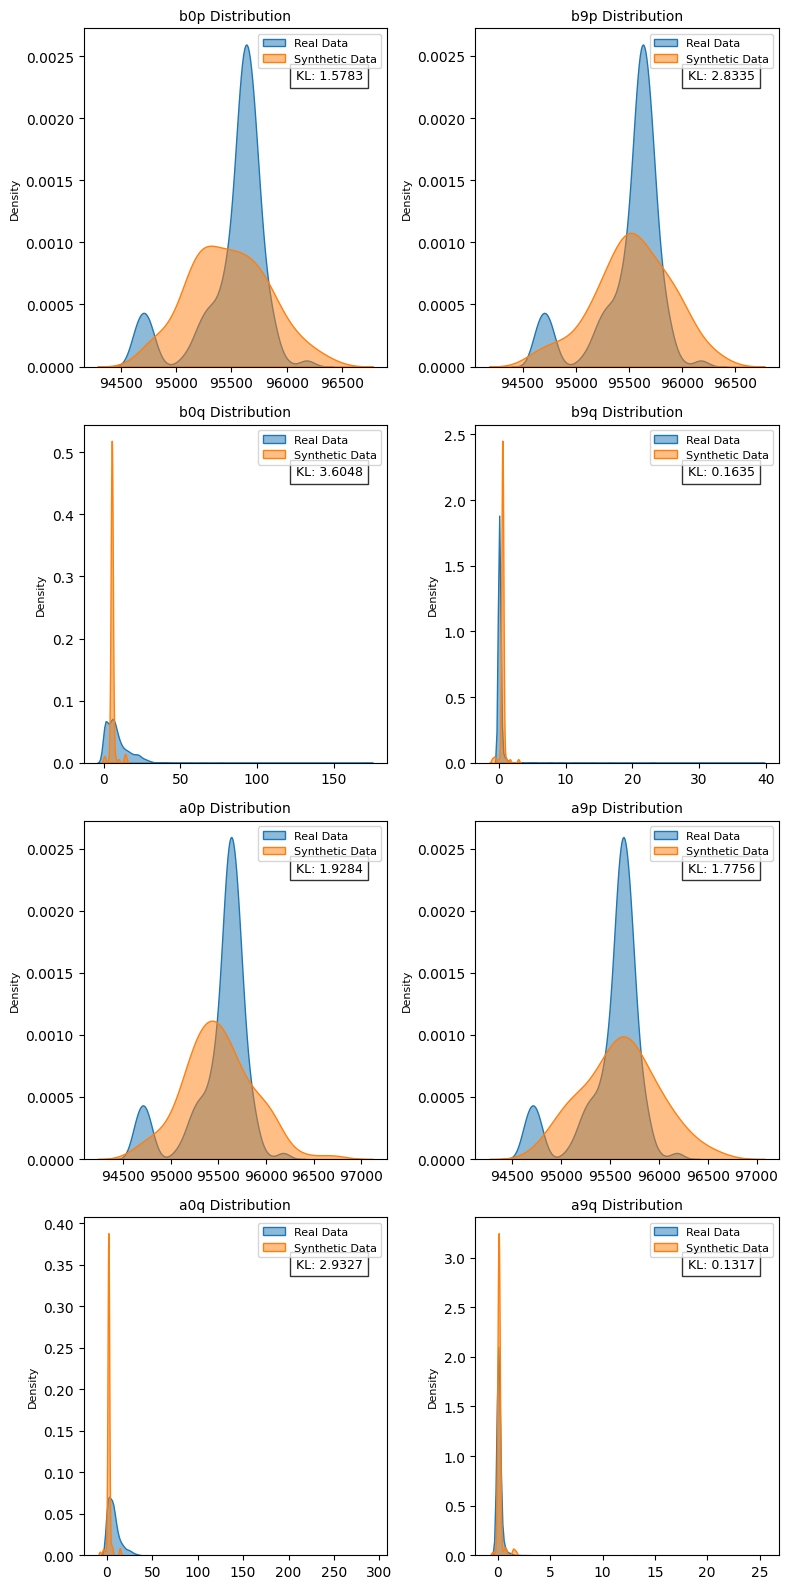

In [56]:
noise = tf.random.normal((100, config.z_dim))
syn_output = trainer.generator(noise)

syn_data = tf.concat(syn_output, axis=1).numpy()
syn_data = scaler.inverse_transform(syn_data)
syn_df = pd.DataFrame(syn_data, columns=lob_features)

results = compare_distributions(real_df, syn_df)

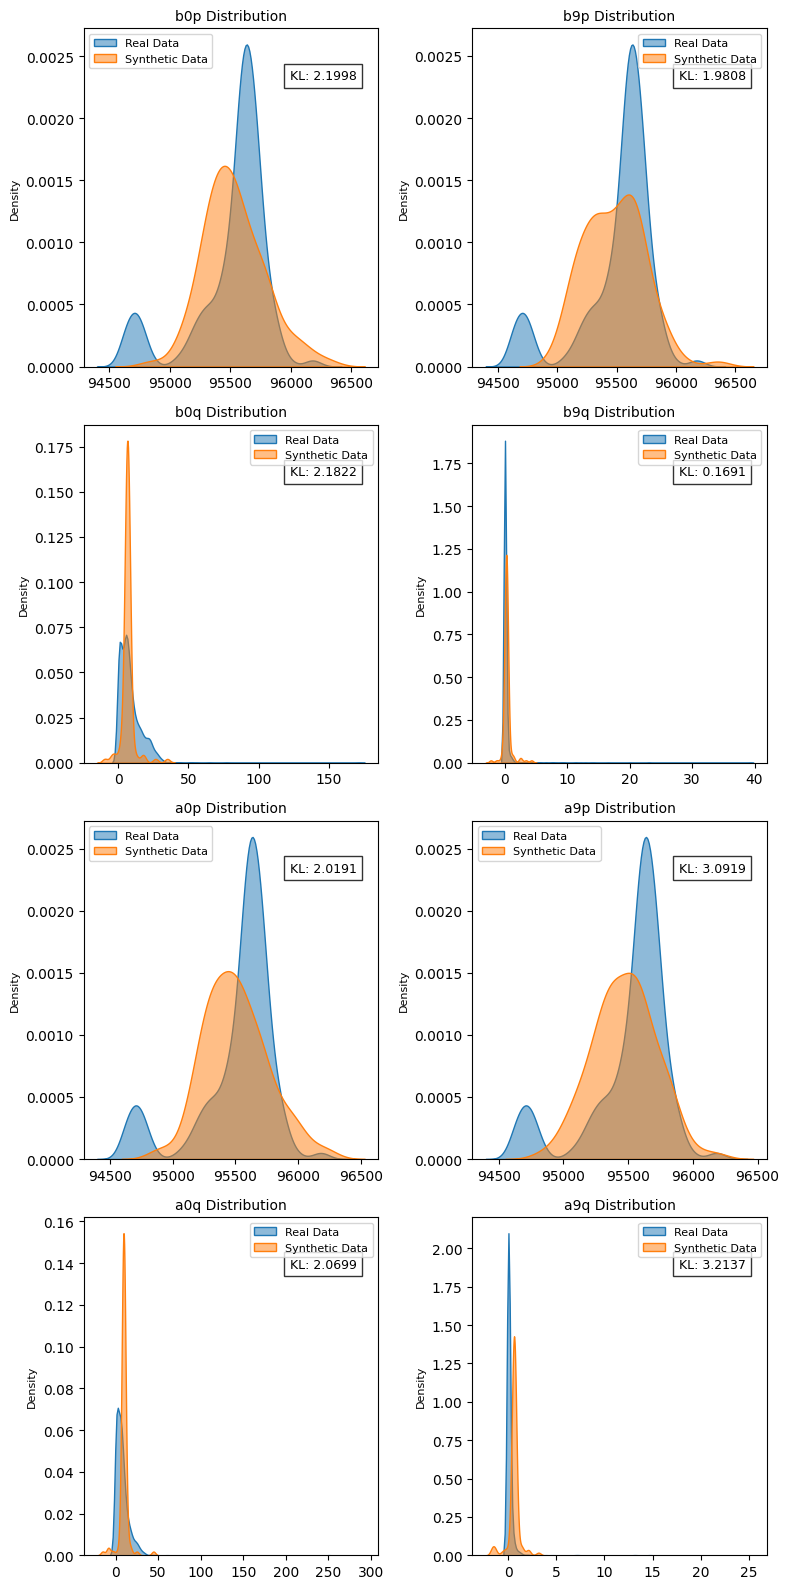

In [58]:
syn_output_ha = trainer_ha.generator(noise)

syn_data_ha = tf.concat(syn_output_ha, axis=1).numpy()
syn_data_ha = scaler.inverse_transform(syn_data_ha)
syn_df_ha = pd.DataFrame(syn_data_ha, columns=lob_features)

results_ha = compare_distributions(real_df, syn_df_ha)

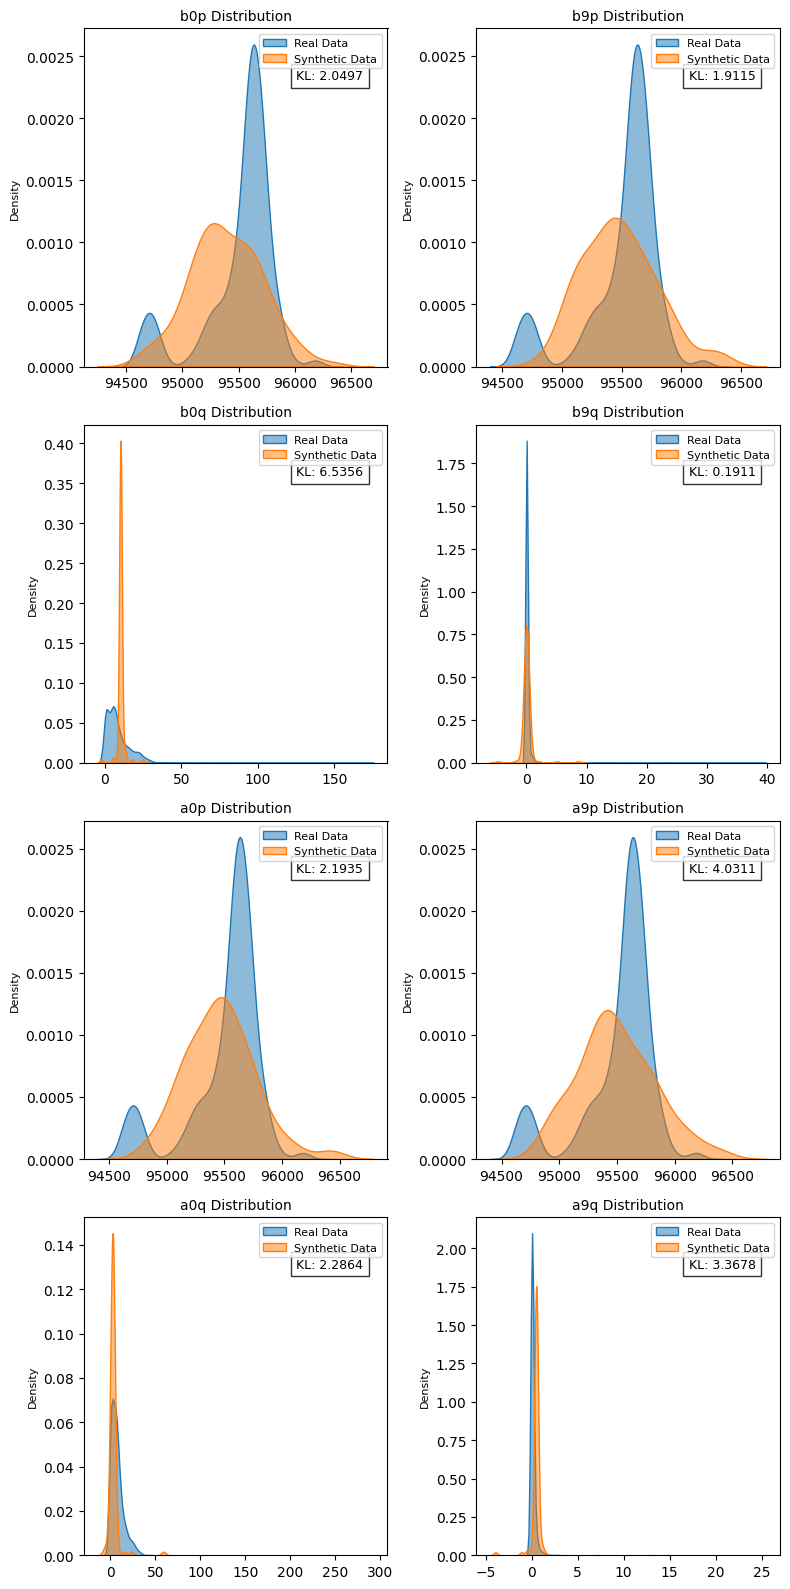

In [61]:
syn_output_ls = trainer_ls.generator(noise)

syn_data_ls = tf.concat(syn_output_ls, axis=1).numpy()
syn_data_ls = scaler.inverse_transform(syn_data_ls)
syn_df_ls = pd.DataFrame(syn_data_ls, columns=lob_features)

results_ls = compare_distributions(real_df, syn_df_ls)

In [62]:
# Comparision Output
print(config.name)
print(f"Max KL divergence：{results['max_kl']:.4f}")
print(f"Min KL divergence：{results['min_kl']:.4f}")
print(f"Avg KL divergence：{results['mean_kl']:.4f}")

print(config_ha.name)
print(f"Max KL divergence：{results_ha['max_kl']:.4f}")
print(f"Min KL divergence：{results_ha['min_kl']:.4f}")
print(f"Avg KL divergence：{results_ha['mean_kl']:.4f}")
improvement_ha = (results['mean_kl'] - results_ha['mean_kl']) / results['mean_kl'] * 100
print(f"Improvement: {improvement_ha:.2f}%")

print(config_ls.name)
print(f"Max KL divergence：{results_ls['max_kl']:.4f}")
print(f"Min KL divergence：{results_ls['min_kl']:.4f}")
print(f"Avg KL divergence：{results_ls['mean_kl']:.4f}")
improvement_ls = (results['mean_kl'] - results_ls['mean_kl']) / results['mean_kl'] * 100
print(f"Improvement: {improvement_ls:.2f}%")

Baseline
Max KL divergence：4.5295
Min KL divergence：0.1317
Avg KL divergence：1.9358
Historical Averaging
Max KL divergence：4.0041
Min KL divergence：0.1673
Avg KL divergence：1.7224
Improvement: 11.02%
One-side Label Smoothing
Max KL divergence：6.5356
Min KL divergence：0.0734
Avg KL divergence：1.8925
Improvement: 2.23%
